# Code Generation with RAG and Self-Correction

Based on [**this tutorial**](https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/)

AlphaCodium presented an approach for code generation that uses control flow.

Main idea: [**construct an answer to a coding question iteratively**](https://x.com/karpathy/status/1748043513156272416?s=20).

[**Alpha Codium**](https://github.com/Codium-ai/AlphaCodium) iteratively tests and improves an answer on public and AI-generated tests for a particular question.

We will implement some of these ideas from scratch using [**LangGraph**](https://python.langchain.com/docs/langgraph)

1. We start with a set of documentation specified by a user.
2. We use a long context LLM to ingest it and perform a RAG to answer a question based upon it.
3. We will invoke a tool to produce a structured output.
4. We will perform two unit tests (check imports and code execution) prior returning the solution to the user.

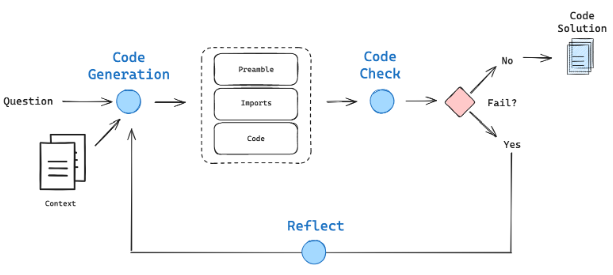

# Setup

In [1]:
from dotenv import load_dotenv
from rich import print as rprint

In [2]:
_ = load_dotenv()

# Docs

Load [**LangChain Expression Language**](https://python.langchain.com/docs/expression_language/) (LCEL) docs as an example

In [3]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

In [4]:
# LCEL docs
url = "https://python.langchain.com/v0.1/docs/expression_language/"

loader = RecursiveUrlLoader(
    url = url,
    max_depth = 20,
    extractor = lambda x: Soup(x, "html.parser").text,  
)

docs = loader.load()

In [5]:
len(docs)

19

In [6]:
for idx, doc in enumerate(docs, 1):
    print(f" Document {idx} ".center(126, '*'))
    rprint(doc.metadata)

********************************************************* Document 1 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'LangChain Expression Language (LCEL) | ğŸ¦œï¸�ğŸ”— LangChain',
    'description': 'LangChain Expression Language, or LCEL, is a declarative way to easily compose chains 
together.',
    'language': 'en'
}

********************************************************* Document 2 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/why/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Advantages of LCEL | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'We recommend reading the LCEL Get started section first.',
    'language': 'en'
}

********************************************************* Document 3 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/how_to/routing/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Route logic based on input | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'This notebook covers how to do routing in the LangChain Expression Language.',
    'language': 'en'
}

********************************************************* Document 4 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/how_to/inspect/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Inspect your runnables | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'Once you create a runnable with LCEL, you may often want to inspect it to get a better sense 
for what is going on. This notebook covers some methods for doing so.',
    'language': 'en'
}

********************************************************* Document 5 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/how_to/decorator/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Create a runnable with the @chain decorator | ğŸ¦œï¸�ğŸ”— LangChain',
    'description': 'You can also turn an arbitrary function into a chain by adding a @chain decorator. This is 
functionally equivalent to wrapping in a RunnableLambda.',
    'language': 'en'
}

********************************************************* Document 6 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/primitives/functions/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Lambda: Run custom functions | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'You can use arbitrary functions in the pipeline.',
    'language': 'en'
}

********************************************************* Document 7 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/primitives/binding/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Binding: Attach runtime args | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'Sometimes we want to invoke a Runnable within a Runnable sequence with constant arguments that 
are not part of the output of the preceding Runnable in the sequence, and which are not part of the user input. We 
can use Runnable.bind() to pass these arguments in.',
    'language': 'en'
}

********************************************************* Document 8 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/get_started/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Get started | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'LCEL makes it easy to build complex chains from basic components, and supports out of the box 
functionality such as streaming, parallelism, and logging.',
    'language': 'en'
}

********************************************************* Document 9 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/interface/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Runnable interface | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'To make it as easy as possible to create custom chains, we\'ve implemented a "Runnable" 
protocol. Many LangChain components implement the Runnable protocol, including chat models, LLMs, output parsers, 
retrievers, prompt templates, and more. There are also several useful primitives for working with runnables, which 
you can read about in this section.',
    'language': 'en'
}

******************************************************** Document 10 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/how_to/message_history/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Add message history (memory) | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'The RunnableWithMessageHistory lets us add message history to certain types of chains. It wraps
another Runnable and manages the chat message history for it.',
    'language': 'en'
}

******************************************************** Document 11 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/streaming/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Streaming | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'Streaming is critical in making applications based on LLMs feel responsive to end-users.',
    'language': 'en'
}

******************************************************** Document 12 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/primitives/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Primitives | ğŸ¦œï¸�ğŸ”— LangChain',
    'description': 'In addition to various components that are usable with LCEL, LangChain also includes various 
primitives',
    'language': 'en'
}

******************************************************** Document 13 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/primitives/passthrough/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Passthrough: Pass through inputs | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'RunnablePassthrough on its own allows you to pass inputs unchanged. This typically is used in 
conjuction with RunnableParallel to pass data through to a new key in the map.',
    'language': 'en'
}

******************************************************** Document 14 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/primitives/parallel/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Parallel: Format data | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'The RunnableParallel primitive is essentially a dict whose values are runnables (or things that
can be coerced to runnables, like functions). It runs all of its values in parallel, and each value is called with 
the overall input of the RunnableParallel. The final return value is a dict with the results of each value under 
its appropriate key.',
    'language': 'en'
}

******************************************************** Document 15 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/primitives/assign/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Assign: Add values to state | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'The RunnablePassthrough.assign(...) static method takes an input value and adds the extra 
arguments passed to the assign function.',
    'language': 'en'
}

******************************************************** Document 16 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/primitives/configure/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Configure runtime chain internals | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'Oftentimes you may want to experiment with, or even expose to the end user, multiple different 
ways of doing things.',
    'language': 'en'
}

******************************************************** Document 17 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/primitives/sequence/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Sequences: Chaining runnables | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'One key advantage of the Runnable interface is that any two runnables can be "chained" together
into sequences. The output of the previous runnable\'s .invoke() call is passed as input to the next runnable. This
can be done using the pipe operator (|), or the more explicit .pipe() method, which does the same thing. The 
resulting RunnableSequence is itself a runnable, which means it can be invoked, streamed, or piped just like any 
other runnable.',
    'language': 'en'
}

******************************************************** Document 18 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/cookbook/multiple_chains/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Multiple chains | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': 'Runnables can easily be used to string together multiple Chains',
    'language': 'en'
}

******************************************************** Document 19 *********************************************************


{
    'source': 'https://python.langchain.com/v0.1/docs/expression_language/cookbook/prompt_size/',
    'content_type': 'text/html; charset=utf-8',
    'title': 'Managing prompt size | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain',
    'description': "Agents dynamically call tools. The results of those tool calls are added back to the prompt, so
that the agent can plan the next action. Depending on what tools are being used and how they're being called, the 
agent prompt can easily grow larger than the model context window.",
    'language': 'en'
}

In [7]:
# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

In [8]:
for idx, doc in enumerate(d_reversed, 1):
    print(f" Document {idx} ".center(126, '*'))
    print(doc.metadata["source"])
    print(len(doc.page_content))

********************************************************* Document 1 *********************************************************
https://python.langchain.com/v0.1/docs/expression_language/why/
17379
********************************************************* Document 2 *********************************************************
https://python.langchain.com/v0.1/docs/expression_language/streaming/
38651
********************************************************* Document 3 *********************************************************
https://python.langchain.com/v0.1/docs/expression_language/primitives/sequence/
6608
********************************************************* Document 4 *********************************************************
https://python.langchain.com/v0.1/docs/expression_language/primitives/passthrough/
3486
********************************************************* Document 5 *********************************************************
https://python.langchain.com/v0.1/docs/express

In [9]:
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [10]:
len(concatenated_content)

278654

In [11]:
type(concatenated_content)

str

# Splitting Context

The context is obviously too large to fit into a context window.

Hence, we will have to split it and implement a RAG mechanism.

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

In [13]:
documents = [Document(page_content=concatenated_content)]

In [14]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 20_000,
    chunk_overlap = 1_000
)
split_docs = text_splitter.split_documents(documents)

In [15]:
len(split_docs)

20

In [16]:
for idx, doc in enumerate(split_docs, 1):
    print(f" Document {idx} ".center(126, '*'))
    print(len(doc.page_content))   

********************************************************* Document 1 *********************************************************
17423
********************************************************* Document 2 *********************************************************
5625
********************************************************* Document 3 *********************************************************
19989
********************************************************* Document 4 *********************************************************
13971
********************************************************* Document 5 *********************************************************
16529
********************************************************* Document 6 *********************************************************
16892
********************************************************* Document 7 *********************************************************
13778
********************************************************* Document 8 *

In [17]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

In [18]:
vectorstore = Chroma.from_documents(split_docs, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

# LLMs

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

## Prompt Template

In [20]:
code_gen_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a coding assistant with expertise in LCEL, LangChain expression language. \n
        Here is a full set of LCEL documentation: \n ------- \n {context} \n ------- \n Answer the user
        question based on the above provided documentation. Ensure any code you provide can be executed \n
        with all required imports and variables defined. Structure your answer with a description of the code solution. \n
        Then list the imports. And finally list the functioning code block. Here is the user question:""",
     ),
     ("placeholder", "{messages}"),
])

## Data Model

In [21]:
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description: str = Field(description="Schema for code solutions to questions about LCEL")

# Chain

In [22]:
from langchain_core.runnables import RunnablePassthrough

In [41]:
# expt_llm = "gpt-3.5-turbo"
expt_llm = "gpt-4o"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"

In [25]:
solution = code_gen_chain.invoke({
    "context": retriever,
    "messages": [("user", question)]
})

In [26]:
rprint(solution)

code(
    prefix="To build a RAG chain in LCEL, you need to use the 'RAGChain' class from the LangChain library. This 
class allows you to create a RAG (Retrieval-Augmented Generation) chain for natural language processing tasks.",
    imports='from langchain import RAGChain',
    code='rag_chain = RAGChain()',
    description="Creating a RAG chain in LCEL using the 'RAGChain' class"
)

# State

Our state is a `dict` that will contain keys (errors, question, code generation) relevant to code generation.

In [27]:
from typing import TypedDict

In [28]:
class GraphState(TypedDict):
    """
    Represents the state of our graph

    Attributes:
        error: Binary flag for control flow to indicate whether test error was tripped
        messages: With user question, error messages, reasoning
        generation: Code solution
        iterations: Number of tries
    """

    error: str
    messages: list
    generation: code
    iterations: int

# Graph

Our graph lays out the logical flow shown in the figure above.

## Parameters

In [29]:
# Max tries
max_iterations = 3
# Reflect
# flag = "reflect"
flag = "do not reflect"

## Nodes

### Generate

In [30]:
def generate(state: GraphState) -> GraphState:
    """
    Generate a code solution

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation
    """
    print(" GENERATING CODE SOLUTION ".center(126, "o"))

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [(
            "user",
            "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:"
        )]

    # Solution
    code_solution = code_gen_chain.invoke({
        "context": retriever,
        "messages": messages
    })
    messages += [(
        "assistant",
        f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}"
    )]

    # Increment
    iterations += 1
    return {
        "generation": code_solution,
        "messages": messages,
    }

### Code Check

In [31]:
def code_check(state: GraphState) -> GraphState:
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to the state, error
    """

    print(" CHECKING CODE ".center(126, "-"))

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print(" CODE IMPORT CHECK: FAILED ".center(126, "~"))
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes"
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print(" CODE BLOCK CHECK: FAILED ".center(126, "!"))
        error_message += [("user", f"Your solution failed the code test: {e}")]
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print(" NO CODE TEST FAILURES ".center(126, "^"))
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }

### Reflect

In [32]:
def reflect(state: GraphState) -> GraphState:
    """
    Reflect on errors

    Args:
        state (dict): The current state graph

    Returns:
        state (dict): New key added to state, generation
    """

    print(" GENERATING CODE SOLUTION ".center(126, "#"))

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]  
    
    # Add reflection
    reflections = code_gen_chain.invoke({
        "context": concatenated_content,
        "messages": messages
    })
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations
    }
    

## Edges

### Decide to Finish

In [33]:
def decide_to_finish(state: GraphState) -> str:
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]
    
    if error == "no" or iterations == max_iterations:
        print(" DECISION: FINISH ".center(126, "="))
        return "end"
    else:
        print(" DECISION: RE-TRY SOLUTION ".center(126, "="))
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

## Compile All

In [34]:
from langgraph.graph import END, StateGraph

In [35]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)
workflow.add_node("check_code", code_check)
workflow.add_node("reflect", reflect)

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    }
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

# Display Graph

In [36]:
from IPython.display import Image, display

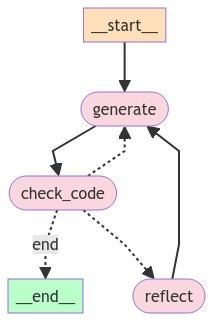

In [37]:
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Run

In [38]:
def invoke_and_display_results(question: str):
    result = app.invoke({"messages": [("user", question)], "iterations": 0})
    rprint(result["generation"].prefix, end="\n\n")
    rprint(result["generation"].imports, end="\n\n")
    rprint(result["generation"].code, end="\n\n")
    rprint(result["generation"].description, end="\n\n")

In [46]:
while True:
    question = input("Ask your question, 'q' to quit: ")
    if question.lower() == "q":
        rprint("[bold yellow]Goodbye![/bold yellow]")
        break
    else:
        invoke_and_display_results(question)

oooooooooooooooooooooooooooooooooooooooooooooooooo GENERATING CODE SOLUTION oooooooooooooooooooooooooooooooooooooooooooooooooo
------------------------------------------------------- CHECKING CODE --------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ CODE IMPORT CHECK: FAILED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
================================================= DECISION: RE-TRY SOLUTION ==================================================
oooooooooooooooooooooooooooooooooooooooooooooooooo GENERATING CODE SOLUTION oooooooooooooooooooooooooooooooooooooooooooooooooo
------------------------------------------------------- CHECKING CODE --------------------------------------------------------
[Document(page_content='This is a sample document.'), Document(page_content='Supreme Court‚Äîthe first Black woman to serve on the court. After The Supreme Court overturned Roe v. Wade, Biden took executive actions, such as the signing of

To use a vectorstore in LCEL, you need to initialize the vectorstore and then use it to store and retrieve vectors.
Here is an example using Chroma and OpenAIEmbeddings:

from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Initialize the embeddings
embeddings = OpenAIEmbeddings()

# Initialize the vectorstore
vectorstore = Chroma(embedding_function=embeddings)

# Example: Adding a document to the vectorstore
document = "This is a sample document."
vectorstore.add_texts()

# Example: Querying the vectorstore
query = "sample"
results = vectorstore.similarity_search(query)
print(results)

This code demonstrates how to initialize a Chroma vectorstore with OpenAIEmbeddings, add a document to the 
vectorstore, and perform a similarity search on the vectorstore.

Goodbye!

In [ ]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"


oooooooooooooooooooooooooooooooooooooooooooooooooo GENERATING CODE SOLUTION oooooooooooooooooooooooooooooooooooooooooooooooooo
------------------------------------------------------- CHECKING CODE --------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ CODE IMPORT CHECK: FAILED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
================================================= DECISION: RE-TRY SOLUTION ==================================================
oooooooooooooooooooooooooooooooooooooooooooooooooo GENERATING CODE SOLUTION oooooooooooooooooooooooooooooooooooooooooooooooooo
------------------------------------------------------- CHECKING CODE --------------------------------------------------------
The input for the prompt is: This is the string to pass to the runnable.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ NO CODE TEST FAILURES ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
======================================

To pass a string to a runnable and use it to construct the input needed for your prompt, you can follow these 
steps:

from langchain_community.vectorstores.chroma import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Define the string you want to pass
your_string = "This is the string to pass to the runnable."

# Construct the input needed for your prompt using the string
input_for_prompt = f"The input for the prompt is: {your_string}"

# Now you can use this input in your prompt or any other operation
print(input_for_prompt)

This code demonstrates how to pass a string to a runnable and use it to construct the input needed for your prompt.
It imports the necessary modules, defines a string, constructs the input using that string, and prints the result.